# Binary Classification with SageMaker XGBoost

**Goal:** Train an XGBoost binary classifier to distinguish **Benign (0)** from **Malicious (1)** network traffic using the 12 engineered features produced by the feature-engineering pipeline.

**Data source:** Feature Store table created from `aai540_eda.dataset_split` (pre-split into `train`, `val`, `test`, `prod` partitions).

**Approach:**
1. Query train / validation / test splits from Athena
2. Upload headerless CSV to S3 (label in the first column — required by SageMaker built-in XGBoost)
3. Run a hyperparameter tuning job (5 trials) optimising **validation AUC**
4. Evaluate the best model on the held-out test set

## Setup

In [44]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker import get_execution_role
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.serializers import CSVSerializer
from sagemaker.inputs import TrainingInput
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, classification_report, confusion_matrix
)

# Initialize Session and Roles
sess = sagemaker.Session()
role = get_execution_role()
region = sess.boto_region_name
bucket = sess.default_bucket()

# Identify your Feature Group 
# Using the naming convention from your Feature Store notebook
sm_client = boto3.client("sagemaker", region_name=region)
fg_list = sm_client.list_feature_groups(NameContains='aai540-ids-splitfs', SortBy='CreationTime', SortOrder='Descending')
latest_fg_name = fg_list['FeatureGroupSummaries'][0]['FeatureGroupName']

netdetect_fg = FeatureGroup(name=latest_fg_name, sagemaker_session=sess)
print(f"Using Feature Group: {latest_fg_name}")

Using Feature Group: aai540-ids-splitfs-v2-20260213-052016


## Retrieve the Training and Validation Sets

In [45]:
def get_dataset_from_feature_store(split_name):
    query = netdetect_fg.athena_query()
    
    # We select the label first (required by SageMaker XGBoost)
    query_string = f"""
    SELECT label, duration, pkt_total, bytes_total, pkt_fwd, pkt_bwd, 
           bytes_fwd, bytes_bwd, pkt_rate, byte_rate, bytes_per_pkt, 
           pkt_ratio, byte_ratio
    FROM "{query.table_name}"
    WHERE data_split = '{split_name}'
    """
    
    output_path = f"s3://{bucket}/aai540/model_training/athena_exports"
    query.run(query_string=query_string, output_location=output_path)
    query.wait()
    
    return query.as_dataframe()

print("Fetching training and validation data from Feature Store...")
train_df = get_dataset_from_feature_store('train')
val_df = get_dataset_from_feature_store('val')

print(f"Retrieved {len(train_df)} training rows and {len(val_df)} validation rows.")

Fetching training and validation data from Feature Store...


INFO:sagemaker:Query cff30d8b-fc0f-41e6-b9cf-0cd4d23e9188 is being executed.
INFO:sagemaker:Query cff30d8b-fc0f-41e6-b9cf-0cd4d23e9188 successfully executed.
INFO:sagemaker:Query 5f5b37c4-1e58-4b12-941c-06fec0a9aeeb is being executed.
INFO:sagemaker:Query 5f5b37c4-1e58-4b12-941c-06fec0a9aeeb successfully executed.


Retrieved 200414 training rows and 50100 validation rows.


## Prepare CSVs for SageMaker XGBoost

In [46]:
# Save locally (no header, no index for SageMaker XGBoost)
train_df.to_csv("train.csv", header=False, index=False)
val_df.to_csv("validation.csv", header=False, index=False)

# Upload to S3
train_uri = sess.upload_data("train.csv", bucket, "aai540/training_input/train")
val_uri = sess.upload_data("validation.csv", bucket, "aai540/training_input/validation")

print(f"Data uploaded to: {train_uri}")

Data uploaded to: s3://sagemaker-us-east-1-128131109986/aai540/training_input/train/train.csv


## Model Training

In [55]:
container = sagemaker.image_uris.retrieve("xgboost", region, "1.7-1")

xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    output_path=f"s3://{bucket}/aai540/model_output",
    sagemaker_session=sess
)

xgb.set_hyperparameters(
    max_depth=6,
    eta=0.2,
    objective="binary:logistic",
    num_round=150,
    eval_metric="auc",
    scale_pos_weight=0.3  # ~normal traffic / attacks
)

xgb.fit({"train": TrainingInput(train_uri, content_type="csv"), 
         "validation": TrainingInput(val_uri, content_type="csv")})

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2026-02-13-07-43-14-099


2026-02-13 07:43:19 Starting - Starting the training job...
2026-02-13 07:43:34 Starting - Preparing the instances for training...
2026-02-13 07:43:55 Downloading - Downloading input data...
2026-02-13 07:44:20 Downloading - Downloading the training image...
2026-02-13 07:45:14 Training - Training image download completed. Training in progress....
2026-02-13 07:45:49 Uploading - Uploading generated training model/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-02-13 07:45:24.663 ip-10-2-192-202.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2026-02-13 07:45:24.743 ip-10-2-192-202.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2026-02-13:0

## Register Model in Model Registry

In [56]:
model_package_group_name = "NetDetect-IDS-Group"

# Create the group if it doesn't exist
try:
    sm_client.create_model_package_group(ModelPackageGroupName=model_package_group_name)
except sm_client.exceptions.ClientError:
    pass # Group already exists

model_package = xgb.register(
    model_package_group_name=model_package_group_name,
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    description="IDS XGBoost Model",
    approval_status="PendingManualApproval"
)
print(f"Model registered in registry: {model_package_group_name}")

Model registered in registry: NetDetect-IDS-Group


## Batch Transform

In [57]:
# Initialize the transformer
transformer = xgb.transformer(
    instance_count=1,
    instance_type='ml.m5.xlarge',
    output_path=f"s3://{bucket}/aai540/batch_results",
    strategy='MultiRecord',
    assemble_with='Line',
    accept='text/csv' 
)

# Start the Transform Job
# input_filter='$[1:]' drops the label column so the model doesn't see the answer.
# join_source='Input' attaches the prediction result back to the original input row.
# output_filter='$[0,-1]' keeps the actual label (index 0) and the new prediction (last index).
transformer.transform(
    data=val_uri, 
    content_type='text/csv',
    split_type='Line',
    input_filter='$[1:]',
    join_source='Input',
    output_filter='$[0,-1]'
)

print("Batch Transform job started. This usually takes 4-6 minutes...")
transformer.wait()

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2026-02-13-07-46-32-345
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2026-02-13-07-46-33-077


.................................
/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-02-13:07:51:57:INFO] No GPUs detected (normal if no gpus installed)
[2026-02-13:07:51:57:INFO] No GPUs detected (normal if no gpus installed)
[2026-02-13:07:51:57:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this packag

## Confusion Matrix and Evaluation Metrics

             NetDetect Model Evaluation (Threshold: 0.05)
  Accuracy  : 0.3971
  Recall    : 0.2199
  AUC-ROC   : 0.8888
------------------------------------------------------------
              precision    recall  f1-score   support

  Benign (0)       0.27      1.00      0.43     11380
  Attack (1)       1.00      0.22      0.36     38720

    accuracy                           0.40     50100
   macro avg       0.64      0.61      0.40     50100
weighted avg       0.84      0.40      0.38     50100



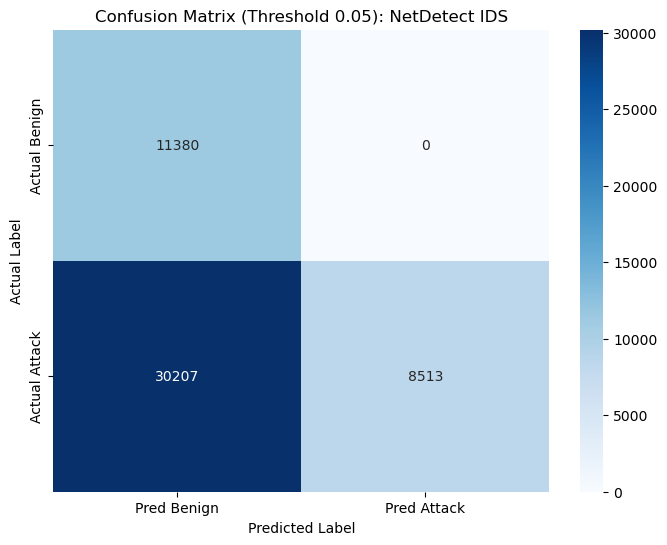

In [58]:
import s3fs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, classification_report, confusion_matrix

fs = s3fs.S3FileSystem()

# Load joined results from S3
output_file = f"s3://{bucket}/aai540/batch_results/validation.csv.out"
with fs.open(output_file, 'rb') as f:
    results = np.loadtxt(f, delimiter=',')

# results[:, 0] = Actual Label (from the 'Input' we joined)
# results[:, 1] = Predicted Probability (from the Model)
y_true = results[:, 0]
y_prob = results[:, 1]

# Lowering this value helps catch more attacks (improves Recall)
# trying 0.1, 0.15, or 0.2 based on previous 0.93 AUC score
threshold = 0.05 
y_pred = (y_prob > threshold).astype(int)
# ------------------------------

# 2. Print Metric Summary
print("=" * 60)
print(f"             NetDetect Model Evaluation (Threshold: {threshold})")
print("=" * 60)
print(f"  Accuracy  : {accuracy_score(y_true, y_pred):.4f}")
print(f"  Recall    : {recall_score(y_true, y_pred):.4f}")
print(f"  AUC-ROC   : {roc_auc_score(y_true, y_prob):.4f}")
print("-" * 60)
print(classification_report(y_true, y_pred, target_names=["Benign (0)", "Attack (1)"]))

# 3. Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred Benign', 'Pred Attack'],
            yticklabels=['Actual Benign', 'Actual Attack'])
plt.title(f'Confusion Matrix (Threshold {threshold}): NetDetect IDS')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Save Model to SageMaker Models

In [59]:
# import boto3
# from time import gmtime, strftime, sleep

# sagemaker_client = boto3.client("sagemaker")

# # Use the job name from your estimator
# model_name = xgb.latest_training_job.name
# print(f"Model Name: {model_name}")

# info = sagemaker_client.describe_training_job(TrainingJobName=model_name)
# model_data = info["ModelArtifacts"]["S3ModelArtifacts"]
# image = container # The XGBoost image used during training

# primary_container = {
#     "Image": image, 
#     "ModelDataUrl": model_data
# }

# # Create the SageMaker Model Object
# create_model_response = sagemaker_client.create_model(
#     ModelName=model_name, 
#     ExecutionRoleArn=role, 
#     PrimaryContainer=primary_container
# )
# print(f"Created Model ARN: {create_model_response['ModelArn']}")

## Create Endpoint Configuration

In [60]:
# endpoint_config_name = 'netdetect-endpoint-config-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
# instance_type = 'ml.m5.xlarge'

# endpoint_config_response = sagemaker_client.create_endpoint_config(
#     EndpointConfigName=endpoint_config_name,
#     ProductionVariants=[
#         {
#             "VariantName": "variant1",
#             "ModelName": model_name, 
#             "InstanceType": instance_type,
#             "InitialInstanceCount": 1
#         }
#     ])
# print(f"Created EndpointConfig: {endpoint_config_response['EndpointConfigArn']}")

## Deploy and Wait for Service

In [61]:
# endpoint_name = 'netdetect-endpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# create_endpoint_response = sagemaker_client.create_endpoint(
#     EndpointName=endpoint_name, 
#     EndpointConfigName=endpoint_config_name
# ) 

# while True:
#     res = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
#     state = res["EndpointStatus"]
#     print(f"Endpoint Status: {state}")
    
#     if state == "InService":
#         break
#     elif state == "Creating":
#         sleep(60)
#     else:
#         print("Creation Error - Check Console")
#         break

## Invoke Endpoint

In [62]:
# sagemaker_runtime = boto3.client("sagemaker-runtime", region_name=region)

# # Grab one sample row (excluding the label)
# # Assuming val_df has the label in column 0
# sample_data = val_df.iloc[0:1, 1:].to_csv(header=None, index=False).strip('\n')

# response = sagemaker_runtime.invoke_endpoint(
#     EndpointName=endpoint_name,
#     ContentType='text/csv',
#     Body=sample_data
# )

# probability = float(response['Body'].read().decode('utf-8'))
# print(f"Raw Probability: {probability}")

# # Apply your custom threshold fix
# prediction = 1 if probability > 0.15 else 0
# print(f"Final Prediction (Threshold 0.15): {prediction}")